# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Analysis

All numbers and figures which appear in the [paper] and much more.

[paper]: https://arxiv.org/abs/1612.01840

In [3]:
%matplotlib inline

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

import utils

sns.set_context("notebook", font_scale=1.5)
plt.rcParams['figure.figsize'] = (17, 5)

In [5]:
tracks = utils.load('../../data/fma_metadata/tracks.csv')
genres = utils.load('../../data/fma_metadata/genres.csv')
features = utils.load('../../data/fma_metadata/features.csv')
echonest = utils.load('../../data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [7]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   (album, comments)            106574 non-null  int64         
 1   (album, date_created)        103045 non-null  datetime64[ns]
 2   (album, date_released)       70294 non-null   datetime64[ns]
 3   (album, engineer)            15295 non-null   object        
 4   (album, favorites)           106574 non-null  int64         
 5   (album, id)                  106574 non-null  int64         
 6   (album, information)         83149 non-null   category      
 7   (album, listens)             106574 non-null  int64         
 8   (album, producer)            18060 non-null   object        
 9   (album, tags)                106574 non-null  object        
 10  (album, title)               105549 non-null  object        
 11  (album, tracks)           

## 1 Size

Todo:
* When are tracks mostly added.
* Which tracks got deleted.

In [79]:
print('{} tracks, {} artists, {} albums, {} genres'.format(
    len(tracks), len(tracks['artist', 'id'].unique()),
    len(tracks['album', 'id'].unique()),
    sum(genres['#tracks'] > 0)))
mean_duration = tracks['track', 'duration'].mean()
print('track duration: {:.0f} days total, {:.0f} seconds average'.format(
    sum(tracks['track', 'duration']) / 3600 / 24,
    mean_duration))

106574 tracks, 16341 artists, 14854 albums, 161 genres
track duration: 343 days total, 278 seconds average


In [80]:
dimensionality = mean_duration * 44000 * 2
print('sample dimensionality: {:.1e}'.format(dimensionality))
print('total size, i.e. number of audio samples: {:.1e}'.format(dimensionality * len(tracks)))

sample dimensionality: 2.4e+07
total size, i.e. number of audio samples: 2.6e+12


In [81]:
for subset in tracks['set', 'subset'].unique():
    indicator = tracks['set', 'subset'] <= subset
    print('{:6} {:6} tracks  {:.1f} days'.format(
        subset, sum(indicator), sum(indicator) * 30 / 3600 / 24))

small    8000 tracks  2.8 days
medium  25000 tracks  8.7 days
large  106574 tracks  37.0 days


48746 deleted tracks (largest track_id is 155320)
First track: 2008-11-25 17:49:06


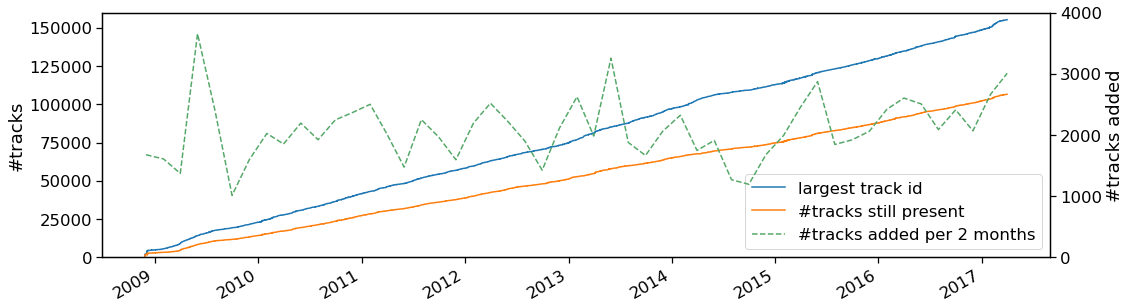

In [83]:
print('{} deleted tracks (largest track_id is {})'.format(tracks.index.max() - len(tracks), tracks.index.max()))
print('First track: {}'.format(tracks['track', 'date_created'].min()))

d = pd.DataFrame(tracks.index, index=tracks['track', 'date_created'].values)
d['indicator'] = 1

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

d['track_id'].plot(ax=ax1)
d['indicator'].cumsum().plot(ax=ax1)
ax1.set_ylabel('#tracks')
ax1.set_ylim(0, 160000)

(d['indicator'] * -100).plot(ax=ax2, style='r')  # needed for no apparent reason
color = sns.color_palette('deep', 3)[2]
d['indicator'].resample('2M').sum().fillna(0).plot(ax=ax2, style='--', color=color)
ax2.set_ylabel('#tracks added')
ax2.set_ylim(500, 4500)
ax2.set_ylim(0, 4000)
ax2.grid(False)

lns = ax1.get_lines() + [ax2.get_lines()[1]]
ax1.legend(lns, ['largest track id', '#tracks still present', '#tracks added per 2 months'], loc='lower right')

# plt.savefig('figures/growth.pdf')

### 1.1 Splits

In [121]:
SPLITS = ['training', 'validation', 'test']
SUBSETS = ['small', 'medium', 'large']
print('subset', '#train', '#val', '#test', 'val_ratio', 'test_ratio', sep="\t")
for subset in SUBSETS:
    counts = [sum((tracks['set', 'split'] == split) & (tracks['set', 'subset'] <= subset)) for split in SPLITS]
    # ratios = np.array(counts[0] / counts[1:])
    ratio_val = (counts[1] / (counts[0] + counts[1]))*100
    ratio_test = (counts[2] / (counts[0] + counts[1] + counts[2]))*100
    print(subset, counts[0], counts[1], counts[2], ratio_val, ratio_test, sep="\t")
    # print('{:8s} {:7d} {:7d} {:7d} {:8.2f} {:9.2f}'.format(subset, *counts, *ratios))

subset	#train	#val	#test	val_ratio	test_ratio
small	6400	800	800	11.11111111111111	10.0
medium	19922	2505	2573	11.169572390422259	10.292
large	84353	10958	11263	11.4970989707379	10.568243661681086


In [123]:
for subset in ['small', 'medium']:
    subset = tracks['set', 'subset'] <= subset

    d = genres.reset_index().set_index('title')
    d = d.loc[tracks.loc[subset, ('track', 'genre_top')].unique()]

    for split in SPLITS:
        b = tracks['set', 'split'] == split
        d['#' + split] = tracks.loc[subset & b, ('track', 'genre_top')].value_counts()

    d['val_ratio'] = d['#training'] / d['#validation']
    d['test_ratio'] = d['#training'] / d['#test']

    ipd.display(d.sort_values('#training', ascending=False))

,genre_id,#tracks,parent,top_level,#training,#validation,#test,val_ratio,test_ratio
title,,,,,,,,,
Hip-Hop,21,8389,0,21,800,100,100,8.0,8.0
Pop,10,13845,0,10,800,100,100,8.0,8.0
Folk,17,12706,0,17,800,100,100,8.0,8.0
Experimental,38,38154,0,38,800,100,100,8.0,8.0
Rock,12,32923,0,12,800,100,100,8.0,8.0
International,2,5271,0,2,800,100,100,8.0,8.0
Electronic,15,34413,0,15,800,100,100,8.0,8.0
Instrumental,1235,14938,0,1235,800,100,100,8.0,8.0


,genre_id,#tracks,parent,top_level,#training,#validation,#test,val_ratio,test_ratio
title,,,,,,,,,
Rock,12,32923,0,12,5681,711,711,7.990155,7.990155
Electronic,15,34413,0,15,5050,632,632,7.990506,7.990506
Experimental,38,38154,0,38,1801,225,225,8.004444,8.004444
Hip-Hop,21,8389,0,21,1761,220,220,8.004545,8.004545
Folk,17,12706,0,17,1215,152,152,7.993421,7.993421
Instrumental,1235,14938,0,1235,1045,131,174,7.977099,6.005747
Pop,10,13845,0,10,945,122,119,7.745902,7.941176
International,2,5271,0,2,814,102,102,7.980392,7.980392
Classical,5,4106,0,5,495,62,62,7.983871,7.983871


In [120]:
d = pd.DataFrame(index=genres.index, columns=SPLITS)
for genre in genres.index:
    b = tracks['track', 'genres_all'].map(lambda genres: genre in genres)
    d.loc[genre] = tracks.loc[b, ('set', 'split')].value_counts()
d['val_ratio'] = d['training'] / d['validation']
d['test_ratio'] = d['training'] / d['test']
d.sort_values('training', ascending=False, inplace=True)
ipd.display(d.head(10))
ipd.display(d.tail(10))

,training,validation,test,val_ratio,test_ratio
genre_id,,,,,
38,29691,4511,3952,6.58191,7.5129
15,27313,3463,3637,7.88709,7.50976
12,25819,3690,3414,6.99702,7.56268
1235,11785,1474,1679,7.99525,7.01906
10,11001,1376,1468,7.99491,7.49387
17,9960,1245,1501,8,6.63558
25,7366,974,921,7.56263,7.99783
1,6865,970,858,7.07732,8.00117
21,6426,961,1002,6.68678,6.41317


,training,validation,test,val_ratio,test_ratio
genre_id,,,,,
444,10,7,8,1.42857,1.25
374,9,NaN,NaN,NaN,NaN
808,8,4,NaN,2,NaN
465,4,4,10,1,0.4
173,3,NaN,1,NaN,3
174,2,1,14,2,0.142857
377,1,NaN,NaN,NaN,NaN
493,1,1,2,1,0.5
175,NaN,NaN,NaN,NaN,NaN


## 2 Metadata

In [124]:
def isnull(column, df=tracks):
    if column[1] in ['tags', 'genres', 'genres_all']:
        return df[column].apply(lambda x: len(x) == 0)
    elif df.dtypes[column] == np.int:
        return df[column] <= 0
    else:
        return df[column].isnull()

def count(series):
    col0 = series.name[0]
    df = tracks if col0 == 'track' else tracks.drop_duplicates((col0, 'id'))
    n = (~isnull(series.name, df)).sum()
    p = n / len(df) * 100
    return n, p

# Columns / metadata usage across dataset.
d = pd.DataFrame(index=tracks.columns.drop('set'), columns=['n', 'p'])
d = d.apply(count, axis=1)
d['n'] = d['n'].astype(np.int)
d

KeyError: 'n'

In [125]:
# Excerpt as example in the paper.
columns = [
    ('track', 'title'),
    ('track', 'genres_all'),
    ('track', 'genre_top'),
    ('track', 'duration'),
    ('track', 'listens'),
    ('album', 'title'),
    ('album', 'listens'),
    ('album', 'tags'),
    ('artist', 'name'),
    ('artist', 'location'),
]

non_null = ~isnull(columns[0])
for column in columns[1:]:
    non_null &= ~isnull(column)
tids = np.random.RandomState(42).permutation(tracks.index[non_null])[:8]

tracks.loc[tids, columns].head()

#tracks.loc[tids, columns].to_latex('figures/tracks.tex', formatters={
#    ('artist', 'longitude'): '{:,.1f}'.format,
#    ('artist', 'latitude'): '{:,.1f}'.format,
#})

track                                          \
                             title      genres_all      genre_top duration   
track_id                                                                     
150073             Welcome to Asia         [2, 79]  International       81   
140943            Sleepless Nights        [322, 5]      Classical      246   
64604     i dont want to die alone   [32, 38, 456]   Experimental      138   
23500              A Life In A Day  [236, 286, 15]     Electronic      264   
131150               Yeti-Bo-Betty    [25, 12, 85]           Rock      124   

                                    album          \
         listens                    title listens   
track_id                                            
150073       683                  Reprise    4091   
140943      1777  Creative Commons Vol. 7   28900   
64604        830        Summer Gut String    7408   
23500       1149          A Life in a Day    6691   
131150       183     No Life After Crypts    3594   

                                                             \
                                                       tags   
track_id                                                      
150073               [world music, dubtronica, fusion, dub]   
140943    [classical, alternate, soundtrack, piano, cont...   
64604     [improvised, minimalist, noise, field recordin...   
23500     [idm, candlestick, romanian, candle, candlesti...   
131150    [richmond, fredericksburg, trash rock, virgini...   

                           artist                            
                             name                  location  
track_id                                                     
150073                   DubRaJah                    Russia  
140943             Dexter Britain            United Kingdom  
64604     Buildings and Mountains               Oneonta, NY  
23500            Candlestickmaker                   Romania  
131150                The Crypts!  Fredericksburg, VA 22401

In [126]:
tracks['track', 'license'].value_counts().head(10)

Attribution-Noncommercial-Share Alike 3.0 United States                          19250
Attribution-NonCommercial-NoDerivatives (aka Music Sharing) 3.0 International    17732
Attribution-NonCommercial-ShareAlike 3.0 International                           15260
Creative Commons Attribution-NonCommercial-NoDerivatives 4.0                     12133
Attribution-Noncommercial-No Derivative Works 3.0 United States                  10584
Attribution-NonCommercial-ShareAlike                                              6907
Attribution                                                                       4991
Attribution-NonCommercial 3.0 International                                       3570
Attribution-NonCommercial                                                         3409
Attribution-ShareAlike                                                            1549
Name: (track, license), dtype: int64

In [127]:
tracks['track', 'language_code'].value_counts().head(10)

en    14255
es      204
fr      191
pt       81
de       68
ru       30
it       28
tr       25
sr       23
ar       12
Name: (track, language_code), dtype: int64

### 2.1 Technical data

count    106574.000000
mean        277.849100
std         305.518553
min           0.000000
25%         149.000000
50%         216.000000
75%         305.000000
max       18350.000000
Name: (track, duration), dtype: float64

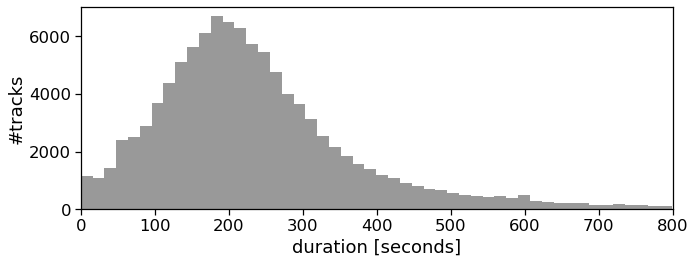

In [129]:
durations = tracks['track', 'duration']
plt.figure(figsize=(10, 4))  # Poster: (7, 3)
p = sns.distplot(durations[durations.values < 800], kde=False, rug=False, color='k', hist_kws=dict(alpha=0.4))
p.set_xlabel('duration [seconds]')
p.set_ylabel('#tracks')
p.set_xlim(0, 800)  # Poster: 500
plt.tight_layout()
# plt.savefig('figures/duration_distribution.pdf')

durations.describe()

Common bit rates: [320000, 256000, 192000, 128000, 160000]
Average bit rate: 263 kbit/s


Text(0, 0.5, '#tracks')

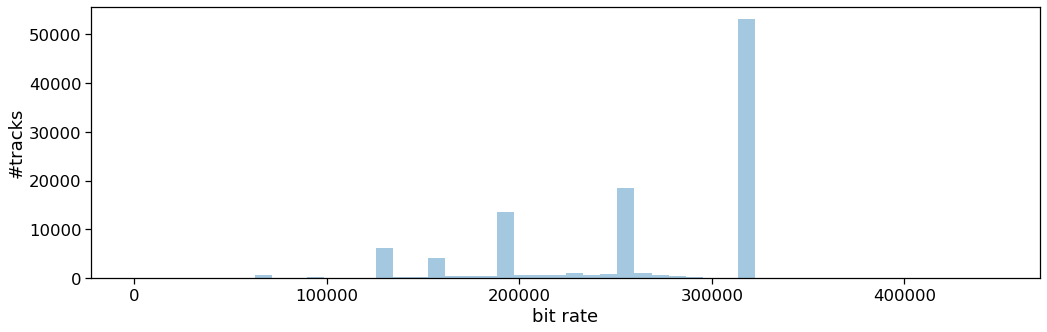

In [135]:
# Uncommon bit rates are VBR encodings.
print('Common bit rates: {}'.format(tracks['track', 'bit_rate'].value_counts().head(5).index.tolist()))
print('Average bit rate: {:.0f} kbit/s'.format(tracks['track', 'bit_rate'].mean()/1000))
p = sns.distplot(tracks['track', 'bit_rate'], kde=False, rug=False)
p.set_xlabel('bit rate')
p.set_ylabel('#tracks')
# p.set_xscale('log')
#p.set_yscale('log');

### 2.2 User data

track: from 0 to 150 tags
album: from 0 to 150 tags
artist: from 0 to 55 tags


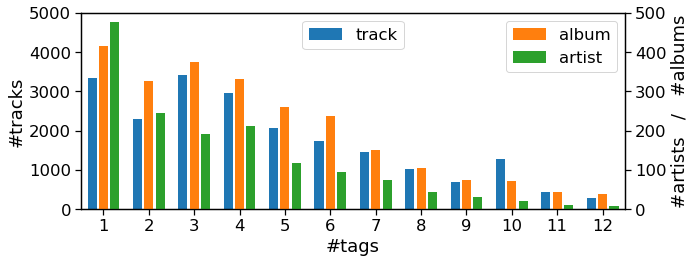

In [137]:
# Tags.
d1 = tracks['track', 'tags'].apply(len)
d2 = tracks.drop_duplicates(('album', 'id'))
d2 = d2['album', 'tags'].apply(len)
d3 = tracks.drop_duplicates(('artist', 'id'))
d3 = d3['artist', 'tags'].apply(len) - 1

labels = ['track', 'album', 'artist']
for l, d in zip(labels, [d1, d2, d3]):
    print('{}: from {} to {} tags'.format(l, max(d.min(), 0), d.max()))

MAX = 13  # Poster: 11
fig, ax1 = plt.subplots(figsize=(10, 4))  # Poster: (7, 3)
ax2 = ax1.twinx()

ax1.hist(d1, bins=np.arange(MAX)+0.25, rwidth=0.2, color='C0', label=labels[0])
ax2.hist(d2, bins=np.arange(MAX)+0.50, rwidth=0.2, color='C1', label=labels[1])
ax2.hist(d3, bins=np.arange(MAX)+0.75, rwidth=0.2, color='C2', label=labels[2])

ax1.set_xlabel('#tags')
ax1.set_ylabel('#tracks')
ax2.set_ylabel('#artists   /   #albums')
ax1.set_xlim(0.5, MAX-0.5)
ax1.set_xticks(range(1, MAX))
ax1.set_ylim(0, 5000)
ax2.set_ylim(0, 500)
ax1.legend(loc='upper center')
ax2.legend(loc='upper right')
ax2.grid(False)

fig.tight_layout()
# fig.savefig('figures/tag_distribution.pdf')

In [138]:
# One artist tag is often the artist name.
col = 'artist'
d = tracks.drop_duplicates((col, 'id'))
d.loc[d[col, 'tags'].apply(len) > 0, [('artist', 'name'), (col, 'tags')]].head()

artist                                                   
                name                                               tags
track_id                                                               
2               AWOL                                             [awol]
10         Kurt Vile                                [philly, kurt vile]
20        Nicky Cook  [instrumentals, experimental pop, post punk, e...
135         Abominog                                         [abominog]
137           Airway                                           [airway]

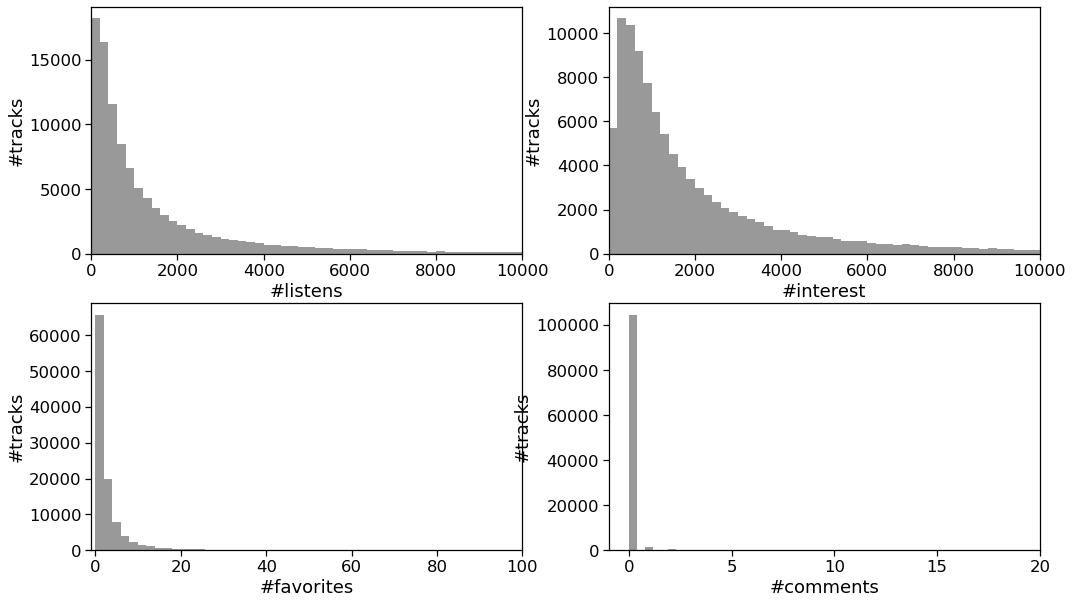

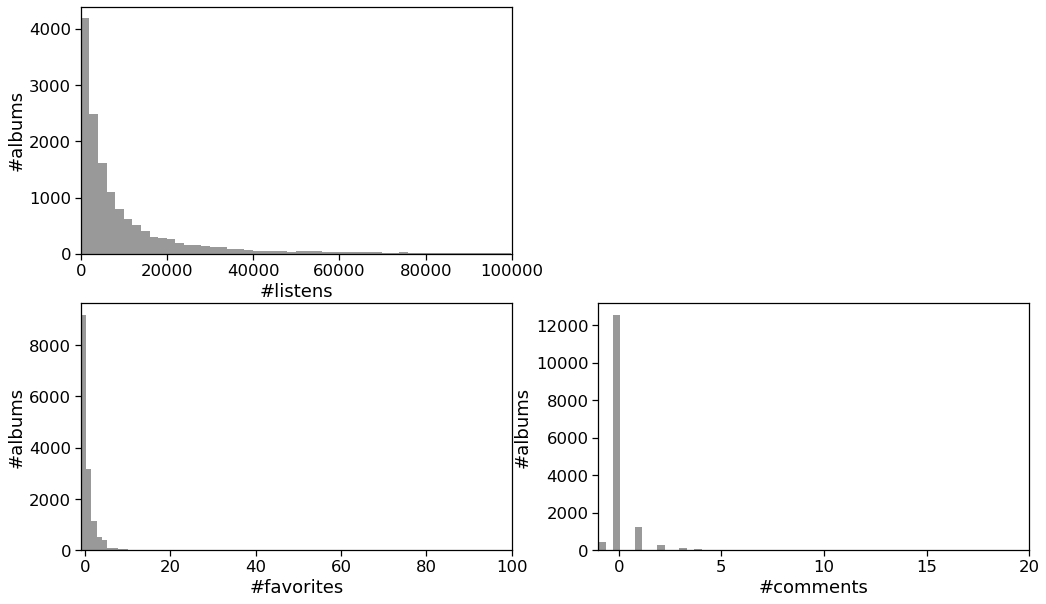

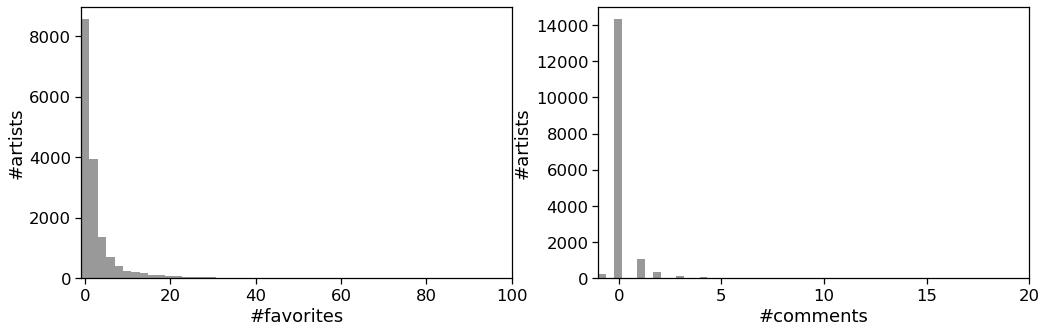

In [139]:
# Listens, favorites, comments.

def plot(col0, col1, maxval, subplot=None):
    if col0 == 'track':
        d = tracks['track']
    if col0 in ['artist', 'album']:
        d = tracks[col0].drop_duplicates('id')
    if subplot:
        plt.subplot(subplot)
    d = d[col1]
    p = sns.distplot(d[d.values < maxval], kde=False, color='k', hist_kws=dict(alpha=0.4))
    p.set_xlim(-1, maxval)
    p.set_xlabel('#' + col1)
    p.set_ylabel('#' + col0 + 's')

plt.figure(figsize=(17, 10))
plot('track', 'listens', 10e3, 221)
plot('track', 'interest', 10e3, 222)
plot('track', 'favorites', 100, 223)
plot('track', 'comments', 20, 224)

plt.figure(figsize=(17, 10))
plot('album', 'listens', 100e3, 221)
plot('album', 'favorites', 100, 223)
plot('album', 'comments', 20, 224)

plt.figure(figsize=(17, 5))
plot('artist', 'favorites', 100, 121)
plot('artist', 'comments', 20, 122)

3564243

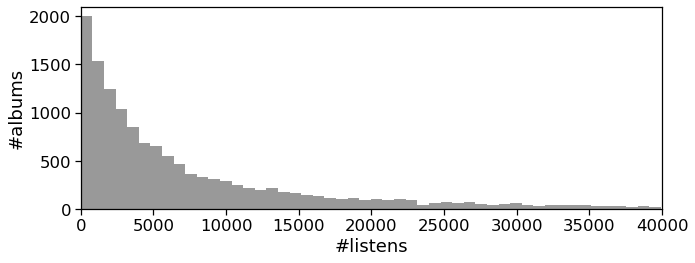

In [141]:
# Same as above, formated for the paper.
plt.figure(figsize=(10, 4))  # Poster: (7, 3)
plot('album', 'listens', 40e3)  # Poster 20e3
plt.tight_layout()
plt.savefig('figures/listens_distribution.pdf')

tracks['album', 'listens'].max()

In [142]:
# Most listened albums.
tracks['album'].groupby('id').first().sort_values('listens', ascending=False).head(10)

,comments,date_created,date_released,engineer,favorites,information,listens,producer,tags,title,tracks,type
id,,,,,,,,,,,,
13010,53,2012-12-06 16:45:52,2012-12-12,NaN,11,"<p><a href=""http://wfmu.org/"" target=""_blank"">...",3564243,NaN,"[music is a belief, chary, nishad, uju, ibiene...",Entries,200,Album
14586,10,2013-07-03 11:51:03,2013-06-28,NaN,55,"<p>29 funky chiptunes from the soundtrack of ""...",1553769,NaN,[],Nameless: The Hackers RPG Soundtrack,29,Album
15736,13,2013-12-30 16:53:43,2014-01-02,NaN,60,"<p>Zabriskie’s move toward the likes of Cage, ...",1363291,NaN,[piano],Cylinders,18,Album
9870,6,2011-08-17 15:18:08,NaT,NaN,31,<p>Jason Shaw's music is a great resource for ...,1282752,NaN,"[1outro, tracks to sync, piano, soft, strings]",Audionautix: Acoustic,40,Album
9615,1,2011-07-15 11:52:14,NaT,NaN,17,<p>A collection of classical tracks recorded b...,1193803,NaN,"[1dance, erik satie, strauss, satie, beethoven...",Classical Sampler,59,Album
10052,5,2011-09-14 19:41:50,2009-09-22,NaN,25,<p>Twenty-three improvised preludes for solo p...,1013245,NaN,[piano],Preludes,23,Album
11948,3,2012-06-17 23:19:50,2012-06-18,NaN,19,NaN,832311,NaN,"[electronic, new age, space, instrumental]",Reappear,7,Album
10927,11,2012-01-25 21:36:45,2012-01-25,NaN,54,NaN,808928,NaN,"[piano, instrumental, melancholy]",Undercover Vampire Policeman,8,Album
10490,0,2011-11-29 11:55:02,2011-12-01,NaN,10,<p>DUBLAB “BONUS BEAT BLAST” – A CREATIVE COMM...,808021,NaN,[],Bonus Beat Blast 2011,74,Album


### 2.3 Dates

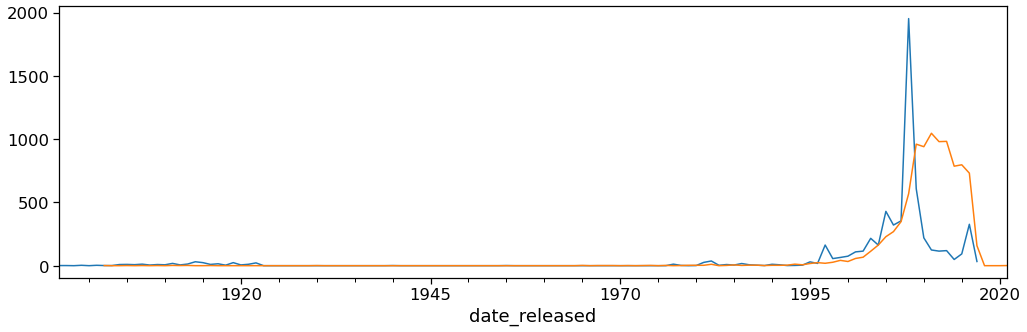

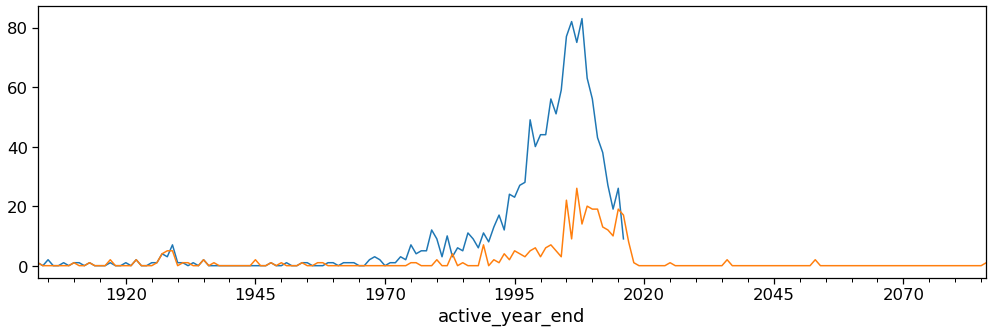

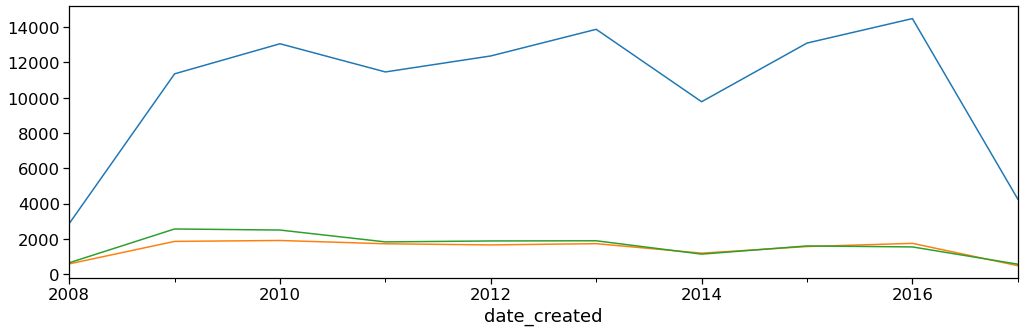

In [143]:
def plot(col0, col1):
    if col0 == 'track':
        d = tracks['track']
    if col0 in ['artist', 'album']:
        d = tracks[col0].drop_duplicates('id')
    d = pd.Series(1, index=d[col1])
    d.resample('A').sum().fillna(0).plot()

plt.figure()
plot('track', 'date_recorded')
plot('album', 'date_released')

plt.figure()
plot('artist', 'active_year_begin')
plot('artist', 'active_year_end')

plt.figure()
plot('track', 'date_created')
plot('album', 'date_created')
plot('artist', 'date_created')

(1902, 2021)

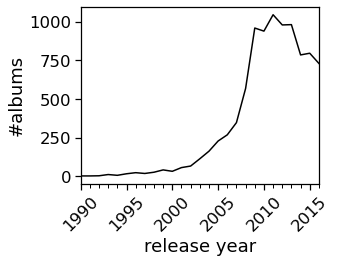

In [148]:
# Same as above, formated for the paper.
plt.figure(figsize=(5, 4))
d = tracks['album'].drop_duplicates('id')
d = pd.Series(1, index=d['date_released'])
d = d.resample('A').sum().fillna(0)
b = d.index >= pd.to_datetime(1990, format='%Y')
b &= d.index <= pd.to_datetime(2017, format='%Y')
d[b].plot(color='k')
plt.xlabel('release year')
plt.ylabel('#albums')
plt.ylabel('#albums')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
# plt.savefig('figures/album_release_year.pdf')

d.index.min().year, d.index.max().year

## 3 Artists & albums effect

15891    745
7168     604
129      499
19461    416
2008     371
Name: (artist, id), dtype: int64

-1        1025
 17509     310
 2275      151
 21841     150
 13010     139
Name: (album, id), dtype: int64

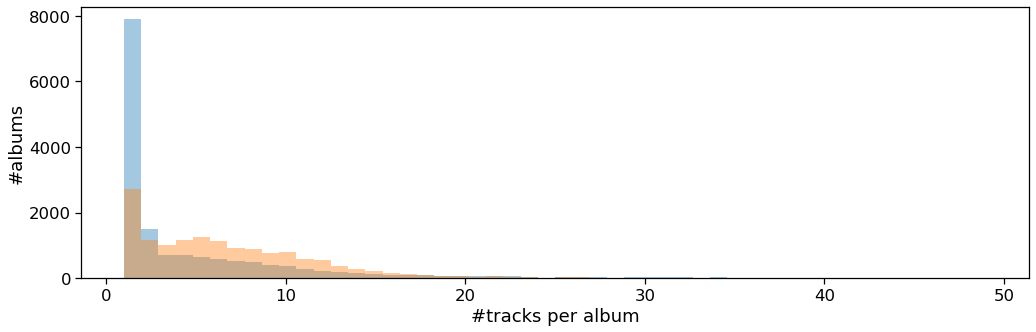

In [149]:
for effect in ['artist', 'album']:
    d = tracks[effect, 'id'].value_counts()
    ipd.display(d.head(5))
    p = sns.distplot(d[(d.values < 50) & (d.values >= 0)], kde=False)
    p.set_xlabel('#tracks per ' + effect);
    p.set_ylabel('#' + effect + 's');

<ipython-input-150-73db298f8785>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  counts = pd.Series(index=genres.loc[genres['parent'] == 0, 'title'].values, name='#artists')


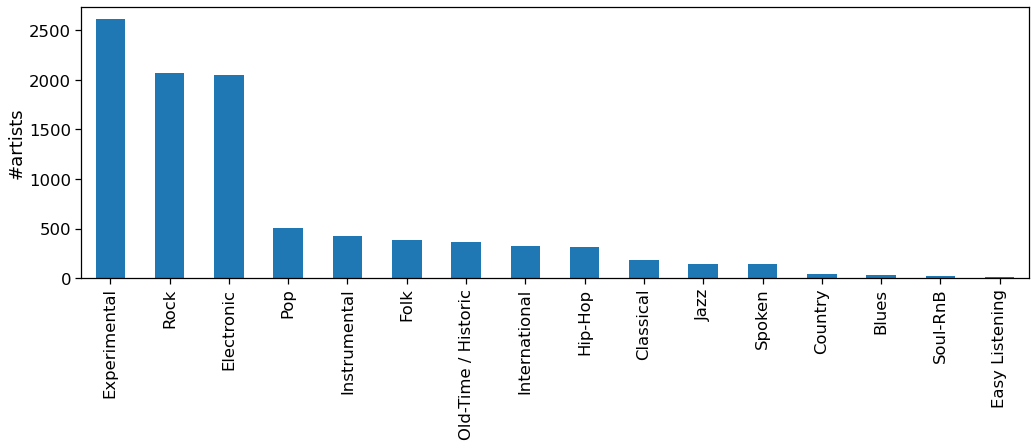

In [150]:
counts = pd.Series(index=genres.loc[genres['parent'] == 0, 'title'].values, name='#artists')
for genre in counts.index:
counts.sort_values(ascending=False).plot.bar()
plt.ylabel('#artists');

## 4 Genres

In [151]:
a = set(tracks['track', 'genre_top'].unique().dropna())
b = set(genres.loc[genres['top_level'].unique(), 'title'].values)
assert a == b

print('{} top-level genres'.format(len(a)))
genres[genres['parent'] == 0].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


Number of genres per track:
* `genres`: they have introduced a [limit of 3 genres per track](https://twitter.com/therewasaguy/status/863426542075953152) early on.
* `genres_all`: more genres per track as all coarser genres in the hierarchy are included. E.g. an Indie-Rock song is counted as a Rock song too.

genres
max: 25 per track: from 0 to 25 tags
genres_all
max: 31 per track: from 0 to 31 tags
#tracks without genre: 2231


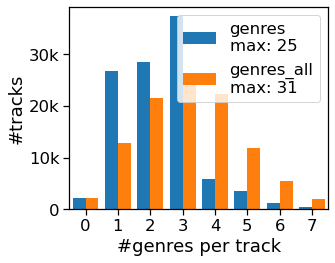

In [153]:
# Genres per track.
labels = ['genres', 'genres_all']  #, 'genres_top']
d = [tracks['track', label].map(len) for label in labels]
labels = ['{}\nmax: {}'.format(label, d1.max()) for label, d1 in zip(labels, d)]

for l, d1 in zip(labels, d):
    print('{} per track: from {} to {} tags'.format(l, d1.min(), d1.max()))
print('#tracks without genre: {}'.format((tracks['track', 'genres'].map(len) == 0).sum()))

MAX = 9
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(d, bins=np.arange(MAX)-0.5, label=labels)
ax.set_xlabel('#genres per track')
ax.set_ylabel('#tracks')
ax.set_xlim(-0.5, MAX-1.5)
ax.set_xticks(range(MAX-1))
ax.set_yticklabels(['0'] + ['{}0k'.format(i) for i in range(1, 6)])
ax.legend(loc='upper right')
fig.tight_layout()
# fig.savefig('figures/genres_per_track.pdf')

(1, 38154)

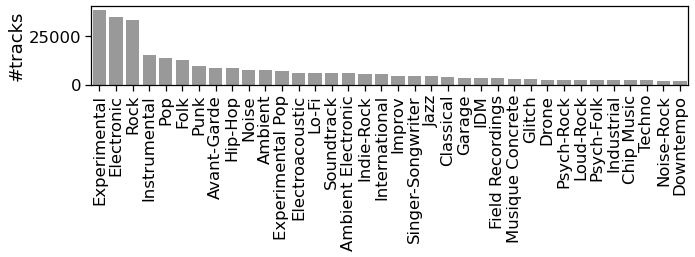

In [154]:
# Number of tracks per genre (full).
d = genres[genres['#tracks'] > 2000].sort_values('#tracks', ascending=False)  # Poster: 5000
plt.figure(figsize=(10, 4))  # Poster: (7, 4)
p = sns.barplot('title', '#tracks', data=d, color='k', alpha=0.4)
p.set_xlabel('')
p.set_ylabel('#tracks')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig('figures/genre_distribution.pdf')

genres.loc[genres['#tracks'] > 0, '#tracks'].min(), genres['#tracks'].max()

Rock                   7103
Electronic             6314
Experimental           2251
Hip-Hop                2201
Folk                   1519
Instrumental           1350
Pop                    1186
International          1018
Classical               619
Old-Time / Historic     510
Jazz                    384
Country                 178
Soul-RnB                154
Spoken                  118
Blues                    74
Easy Listening           21
Name: (track, genre_top), dtype: int64

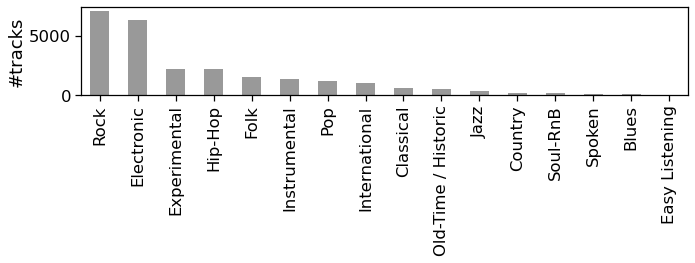

In [155]:
# Number of tracks per top-level genre (medium).
d = tracks[tracks['set', 'subset'] <= 'medium']
d = d['track', 'genre_top'].value_counts()
plt.figure(figsize=(10, 4))  # Poster: (7, 4)
d.plot.bar(color='k', alpha=0.4)
plt.ylabel('#tracks')
plt.xlabel('')
plt.tight_layout()
# plt.savefig('figures/genre_top_distribution.pdf')

d

### 4.1 Genre hierarchy

* As genres have parent genres, we can plot a tree using the [DOT] language.
* Save the full genre tree as a PDF.

Todo:
* Color nodes according to FMA genre color.
* Better looking tree.

[DOT]: https://en.wikipedia.org/wiki/DOT_(graph_description_language)

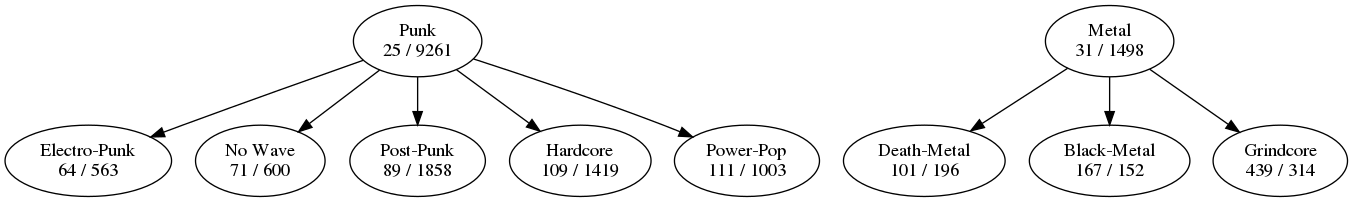

In [156]:
g = utils.Genres(genres)
graph = g.create_tree([25, 31], 1)
ipd.Image(graph.create_png())

In [158]:
graph = g.create_tree(14)
g# raph.write_pdf('figures/genre_hierarchy.pdf');

roots = g.find_roots()
print('{} roots'.format(len(roots)))
graph = g.create_tree(roots)
# graph.write_pdf('figures/genre_hierarchy.pdf');

16 roots


### 4.2 Cross-appearance

Todo:
* Group rows and columns for better identification of related genres.

In [159]:
enc = MultiLabelBinarizer()
genres_indicator = enc.fit_transform(tracks['track', 'genres'])
genres_names = enc.classes_
genres_names = genres.loc[enc.classes_, 'title'].values
cross_correlation = genres_indicator.T @ genres_indicator

<ipython-input-161-8c6e1492d0d4>:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(cross_correlation))


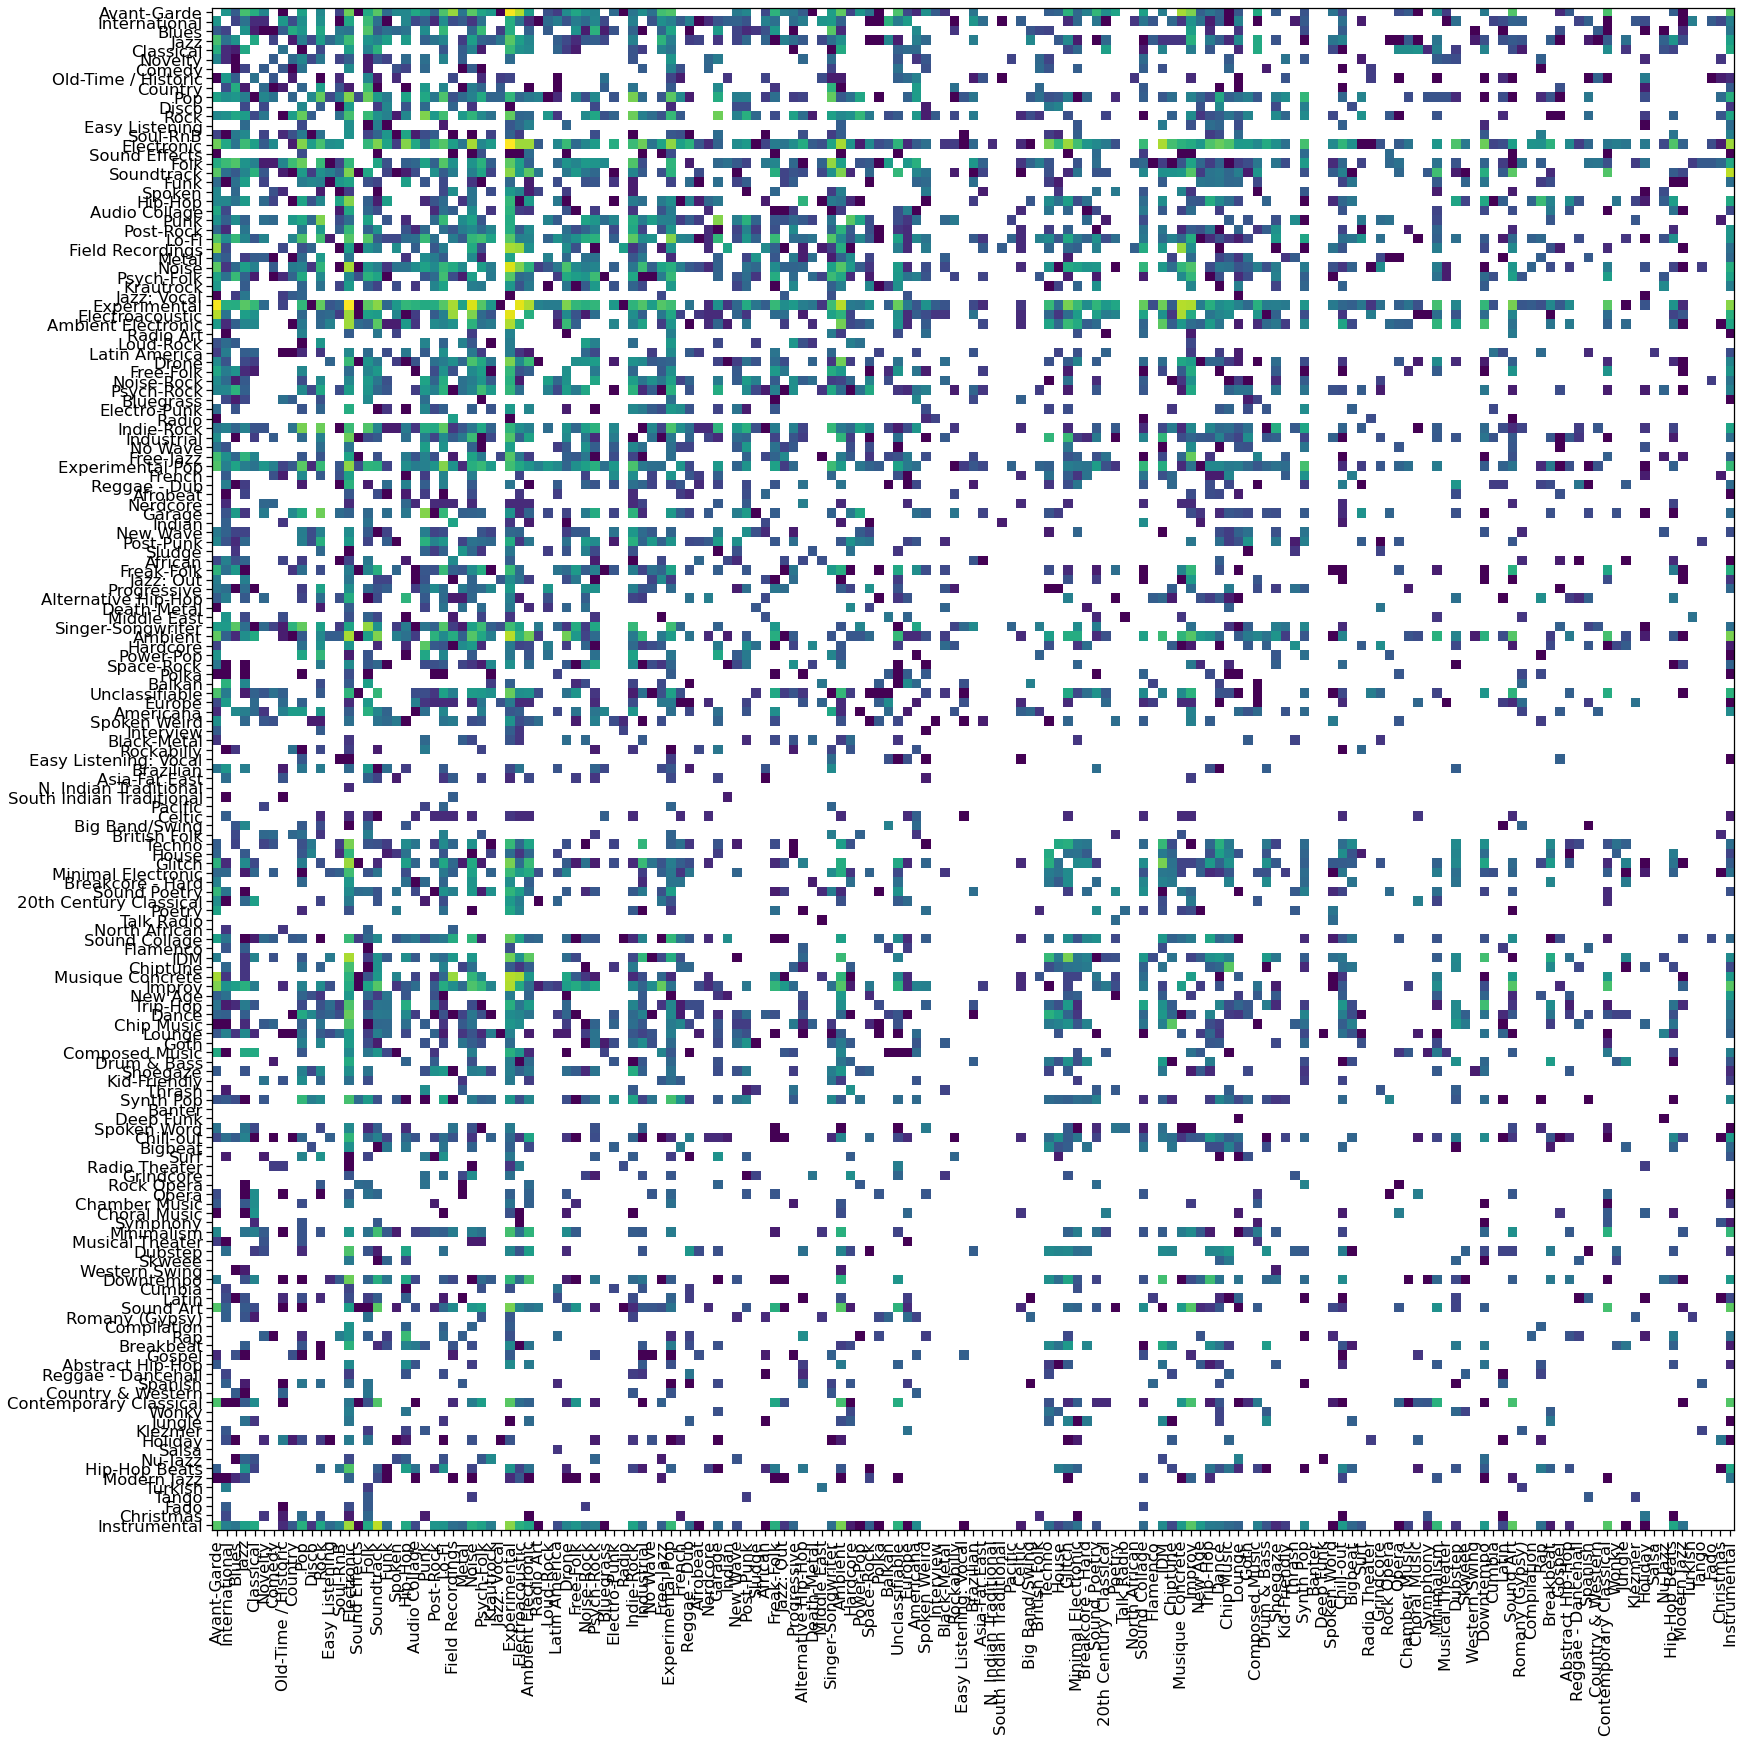

In [161]:
np.fill_diagonal(cross_correlation, 0)

plt.figure(figsize=(28, 28))
plt.imshow(np.log(cross_correlation))
plt.yticks(range(len(genres_names)), genres_names);
plt.xticks(range(len(genres_names)), genres_names, rotation=90);

In [162]:
cross_correlation = np.tril(cross_correlation, k=-1)
sort = np.argsort(cross_correlation.flatten())

N = 20
indices = np.unravel_index(sort[:-N:-1], cross_correlation.shape)
for i, j in zip(*indices):
    print('{}: {} | {}'.format(cross_correlation[i, j], genres_names[i], genres_names[j]))

6771: Experimental | Electronic
6088: Experimental | Avant-Garde
4782: Electroacoustic | Experimental
4121: Experimental | Noise
2783: Instrumental | Soundtrack
2663: Ambient | Experimental
2555: Electroacoustic | Avant-Garde
2507: Musique Concrete | Experimental
2385: Improv | Experimental
2250: Ambient Electronic | Experimental
2230: IDM | Electronic
2183: Musique Concrete | Electroacoustic
2122: Experimental | Field Recordings
2099: Ambient | Electronic
2097: Noise | Electronic
2049: Musique Concrete | Avant-Garde
1888: Instrumental | Electronic
1838: Electroacoustic | Electronic
1834: Ambient Electronic | Electronic


## 5 Audio

Todo: e.g. audio features (echonest / librosa, spectrograms) to show diversity.

## 6 Features

Todo: understand features by listening to segments who have them, e.g. <http://musicinformationretrieval.com/feature_sonification.html>.

In [163]:
features.head(5).style.format('{:.2f}')

KeyError: "['mean' '01'] not in index"

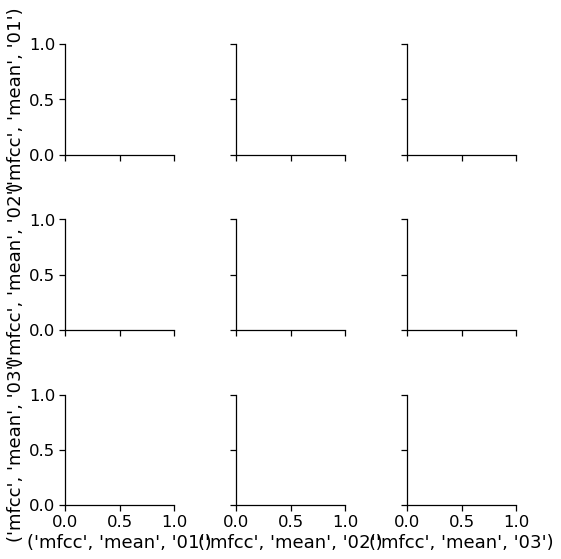

In [164]:
sns.pairplot(features.loc[:, ('mfcc', 'mean', slice('01','03'))]);
sns.pairplot(features.loc[:, ('mfcc', 'std', slice('01','03'))]);

## 7 Echonest features

In [165]:
print('Echonest features available for {} tracks.'.format(len(echonest)))

Echonest features available for 13129 tracks.
